## dataset.ipynb: preprocess the dataset 

In [6]:
# Import the necessary libraries
import numpy as np
import cv2
from sklearn.decomposition import PCA
import scipy.io as sio
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn import preprocessing
import os
import random
from random import shuffle
from skimage.transform import rotate
import scipy.ndimage
import spectral 

In [2]:
#  load the Indian pines dataset which is the .mat format
def loadIndianPinesData():
    data_path = os.path.join(os.getcwd(), 'data')
    data = sio.loadmat(os.path.join(data_path, 
                      'Indian_pines.mat'))['indian_pines']
    labels = sio.loadmat(os.path.join(data_path, 
                        'Indian_pines_gt.mat'))['indian_pines_gt']
    
    return data, labels

In [2]:
#  load the Indian pines dataset which is HSI format
#  refered from http://www.spectralpython.net/fileio.html
def loadHSIData():
    data_path = os.path.join(os.getcwd(), 'HSI_data')
    data = open_image(os.path.join(data_path, '92AV3C.lan')).load()
    data = np.array(data).astype(np.int32)
    labels = open_image(os.path.join(data_path, '92AV3GT.GIS')).load()
    labels = np.array(labels).astype(np.uint8)
    labels.shape = (145, 145)
    return data, labels

In [3]:
# 显示超立方图
data, labels = loadHSIData()
spectral.settings.WX_GL_DEPTH_SIZE = 100
view_cube(data, bands=[29, 19, 9])

D:\Anaconda\envs\tf-gpu-25\lib\site-packages\spectral\graphics\graphics.py:758: UserWarning: 
There is no current wx.App object - creating one now.
  UserWarning)


In [4]:
#  split data to Train and Test Set
def splitTrainTestSet(X, y, classnum=15, testRatio=0.20):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                test_size=testRatio, random_state=345, stratify=y)
    ss=StratifiedShuffleSplit(n_splits=classnum, test_size=testRatio, 
                              train_size=1-testRatio, random_state=0)
    
    for train_index, test_index in ss.split(X, y):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
    return X_train, X_test, y_train, y_test

In [5]:
#  over sample 
def oversampleWeakClasses(X, y):
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts  
    # repeat for every label and concat
    newX = X[y == uniqueLabels[0], :, :, :].repeat(round(labelInverseRatios[0]), 
                                                   axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :, :, :]
    newY = newY[rand_perm]
    return newX, newY

In [6]:
#  standartize
def standartizeData(X):
    newX = np.reshape(X, (-1, X.shape[2]))
    scaler = preprocessing.StandardScaler().fit(newX)  
    newX = scaler.transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1],X.shape[2]))
    return newX, scaler

In [7]:
#  apply PCA preprocessing for data sets
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [8]:
#  pad zeros to dataset
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, 
                     X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + 
         y_offset, :] = X
    return newX

In [9]:
#  create Patches for dataset
def createPatches(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, 
                            windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - 
                                margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [10]:
#  Augment Data
def AugmentData(X_train):
    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):
            
            flipped_patch = np.flipud(patch)
        if (num == 1):
            
            flipped_patch = np.fliplr(patch)
        if (num == 2):
            
            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, 
                            no,axes=(1, 0), reshape=False, output=None, 
                            order=3, mode='constant', cval=0.0, prefilter=False)
        
    patch2 = flipped_patch
    X_train[i,:,:,:] = patch2
    
    return X_train

In [12]:
# save Preprocessed Data to file
def savePreprocessedData(path, X_trainPatches, X_testPatches, y_trainPatches, 
                         y_testPatches, X_all, y_all, windowSize, wasPCAapplied = False, 
                         numPCAComponents = 0, testRatio = 0.25):
    
    data_path = os.path.join(os.getcwd(), path)

    if wasPCAapplied:
        with open(os.path.join(data_path, "XtrainWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_trainPatches)
        with open(os.path.join(data_path, "XtestWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_testPatches)
        with open(os.path.join(data_path, "ytrainWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_trainPatches)
        with open(os.path.join(data_path, "ytestWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_testPatches)
        
        with open(os.path.join(data_path, "XAllWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_all)
        with open(os.path.join(data_path, "yAllWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_all)
    else:
        with open(os.path.join(data_path, "preXtrainWindowSize") + str(windowSize) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_trainPatches)
        with open(os.path.join(data_path, "preXtestWindowSize") + str(windowSize) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_testPatches)
        with open(os.path.join(data_path, "preytrainWindowSize") + str(windowSize) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_trainPatches)
        with open(os.path.join(data_path, "preytestWindowSize") + str(windowSize) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_testPatches)
            

In [13]:
# Global Variables
# The number of principal components to be retained in the PCA algorithm, 
# the number of retained features  n
numComponents = 30
# Patches windows size
windowSize = 5
# The proportion of Test sets
testRatio = 0.20

In [14]:
# Load dataset from file and apply PCA
X, y = loadHSIData()
# X, y = loadIndianPinesData()
X, pca = applyPCA(X, numComponents=numComponents)

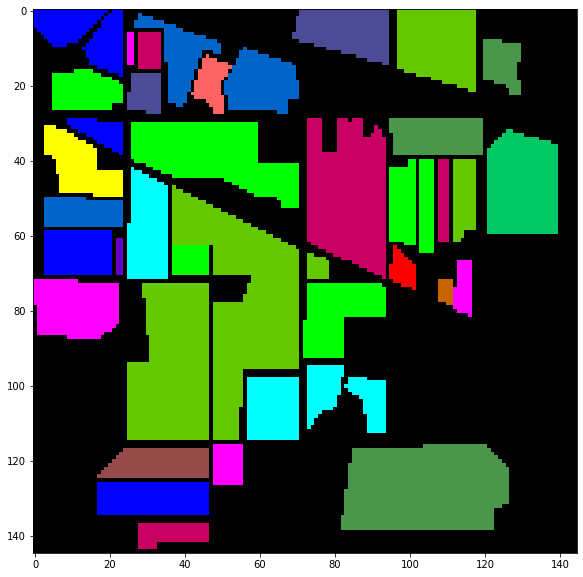

In [15]:
ground_truth = imshow(classes=y, figsize=(10, 10))

In [16]:
# Preprocess Data
XPatches, yPatches = createPatches(X, y, windowSize=windowSize)
X_train, X_test, y_train, y_test = splitTrainTestSet(XPatches, yPatches, 
                                                     y.max()-y.min(), testRatio)
X_all = np.append(X_train, X_test, axis=0)
y_all = np.append(y_train, y_test, axis=0)
X_train, y_train = oversampleWeakClasses(X_train, y_train)
# X_all, y_all = oversampleWeakClasses(X_all, y_all)
X_train = AugmentData(X_train)
# X_all = AugmentData(X_all)

TRAIN: [ 6808  1018  5090 ...  6640  8427 10169] TEST: [7876 4591 2229 ... 7871 4556 4268]
TRAIN: [ 388 1351 8426 ... 7972 3865 3123] TEST: [8731 1006 2648 ... 7748 9526 2574]
TRAIN: [  955  2616 10222 ...  1113  9956  5676] TEST: [1911 4886 8093 ... 4416 3419 8160]
TRAIN: [  480  6409 10142 ...  5973  1242  4276] TEST: [ 5750 10022  2446 ...  1650 10088  8362]
TRAIN: [1341  429 1153 ... 4035 9595 6896] TEST: [ 8672  4759  1515 ...  6063  4526 10213]
TRAIN: [ 4549  8543  2942 ... 10294   985   825] TEST: [ 9159  4752  8147 ...  1975 10041  9115]
TRAIN: [ 211  534 8190 ... 2007 5149 5396] TEST: [3144 9547 5028 ... 6284 6268 9302]
TRAIN: [6612 9988 2062 ...  689 4895 1583] TEST: [ 6643   359   969 ...  6008  5072 10299]
TRAIN: [5973 6273 5957 ... 9051 5916 6934] TEST: [ 5858  4847  6217 ...  6443 10052  2131]
TRAIN: [ 670 2628 1825 ... 1562 1646 6321] TEST: [1591 7659 4536 ... 6084 4514 8825]
TRAIN: [3852 4270 2066 ... 9511 7417  428] TEST: [4691 9661 5341 ... 2165 8263 6779]
TRAIN: [ 93

In [17]:
# save Preprocessed Data to file
savePreprocessedData('predata', X_train, X_test, y_train, y_test, 
                     X_all, y_all, windowSize = windowSize, 
                     wasPCAapplied=True, numPCAComponents = numComponents, 
                     testRatio = testRatio)

In [18]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
XPatches, yPatches = createPatches(X, y, windowSize=windowSize)
ss=StratifiedShuffleSplit(n_splits=y.max()-y.min(), test_size=testRatio, 
                              train_size=1-testRatio, random_state=0)
    
for train_index, test_index in ss.split(XPatches, yPatches):
    print("TRAIN:", train_index, "TEST:", test_index)#获得索引值
    X_train, X_test = XPatches[train_index], XPatches[test_index]#训练集对应的值
    y_train, y_test = yPatches[train_index], yPatches[test_index]#类别集对应的值

TRAIN: [ 6808  1018  5090 ...  6640  8427 10169] TEST: [7876 4591 2229 ... 7871 4556 4268]
TRAIN: [ 388 1351 8426 ... 7972 3865 3123] TEST: [8731 1006 2648 ... 7748 9526 2574]
TRAIN: [  955  2616 10222 ...  1113  9956  5676] TEST: [1911 4886 8093 ... 4416 3419 8160]
TRAIN: [  480  6409 10142 ...  5973  1242  4276] TEST: [ 5750 10022  2446 ...  1650 10088  8362]
TRAIN: [1341  429 1153 ... 4035 9595 6896] TEST: [ 8672  4759  1515 ...  6063  4526 10213]
TRAIN: [ 4549  8543  2942 ... 10294   985   825] TEST: [ 9159  4752  8147 ...  1975 10041  9115]
TRAIN: [ 211  534 8190 ... 2007 5149 5396] TEST: [3144 9547 5028 ... 6284 6268 9302]
TRAIN: [6612 9988 2062 ...  689 4895 1583] TEST: [ 6643   359   969 ...  6008  5072 10299]
TRAIN: [5973 6273 5957 ... 9051 5916 6934] TEST: [ 5858  4847  6217 ...  6443 10052  2131]
TRAIN: [ 670 2628 1825 ... 1562 1646 6321] TEST: [1591 7659 4536 ... 6084 4514 8825]
TRAIN: [3852 4270 2066 ... 9511 7417  428] TEST: [4691 9661 5341 ... 2165 8263 6779]
TRAIN: [ 93

In [19]:
print(X_train.size)
print(y_train.size)
print(X_test.size)
print(y_test.size)

6219000
8292
1555500
2074


In [5]:
a=16
height = 15
width = 40
outputs = np.zeros((15,40))  
for i in range(height):
    for j in range(width):
        outputs[i][j] = a
spectral.save_rgb("{}.png".format(a), outputs.astype(int), colors=spectral.spy_colors)        

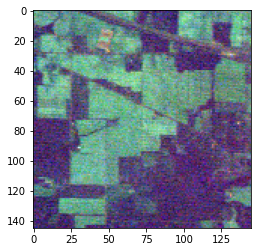

In [8]:
img = spectral.open_image('HSI_data/92AV3C.lan')
img_1 = img[:,:,19].reshape(145,145)
view = spectral.imshow(img)
# cv2.imshow('1',img_1)
# cv2.waitKey(0)